In [2]:
!pip install torch torchvision torchaudio transformers scikit-learn pandas numpy matplotlib

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix

# Load dataset
df = pd.read_csv('/kaggle/input/new-hsioa/final_labels.csv')

# Preprocessing
# Drop null values
df.dropna(subset=['body', 'level_1'], inplace=True)

# Encode labels (toxic = 1, non-toxic = 0)
df['label'] = df['level_1'].apply(lambda x: 1 if x.lower() == 'misogynistic' else 0)

# Split dataset based on 'split' column
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

train_texts, train_labels = train_df['body'], train_df['label']
test_texts, test_labels = test_df['body'], test_df['label']

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_texts(texts):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_texts(train_texts)
test_encodings = tokenize_texts(test_texts)

# Custom Dataset
class ToxicCommentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

train_dataset = ToxicCommentDataset(train_encodings, train_labels)
test_dataset = ToxicCommentDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

# Training Loop
def train_model(model, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = criterion(outputs.logits, batch['labels'])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")

# Evaluation Metrics
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='micro')
    auc_roc = roc_auc_score(all_labels, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    fpr, fnr = fp / (fp + tn), fn / (fn + tp)
    
    print(f"Micro Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")

# Train and Evaluate
train_model(model, train_loader)
evaluate_model(model, test_loader)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 1, Loss: 0.2633360422507925
Epoch 2, Loss: 0.16927694937067056
Epoch 3, Loss: 0.12246165919368153
Epoch 4, Loss: 0.07604410328409043
Epoch 5, Loss: 0.033234350891625665
Epoch 6, Loss: 0.024951390573376468
Epoch 7, Loss: 0.01667665758248122
Epoch 8, Loss: 0.02136163560912529
Epoch 9, Loss: 0.009157474622651256
Epoch 10, Loss: 0.013909886974727595
Micro Precision: 0.9347
Recall: 0.9347
F1 Score: 0.9347
AUC-ROC: 0.6981
False Positive Rate (FPR): 0.0068
False Negative Rate (FNR): 0.5969


In [4]:
import torch
from transformers import BartForConditionalGeneration, BartTokenizer

# Load BART model for rewriting
bart_tokenizer = BartTokenizer.from_pretrained("eugenesiow/bart-paraphrase")
bart_model = BartForConditionalGeneration.from_pretrained("eugenesiow/bart-paraphrase")

# Function to rewrite text after removing toxicity
def rewrite_text(text):
    input_ids = bart_tokenizer(text, return_tensors="pt", truncation=True, max_length=128).input_ids
    output_ids = bart_model.generate(input_ids, max_length=128, num_return_sequences=1, do_sample=True, temperature=0.7)
    return bart_tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Example usage
text = "Women should not be in leadership positions!"
rewritten = rewrite_text(text)
print(f"✅ Suggested: {rewritten}")


tokenizer_config.json:   0%|          | 0.00/332 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

✅ Suggested: Why should women not be in leadership positions?


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Micro Precision: 0.9347
Recall: 0.9347
F1 Score: 0.9347
AUC-ROC: 0.6981
False Positive Rate (FPR): 0.0068
False Negative Rate (FNR): 0.5969


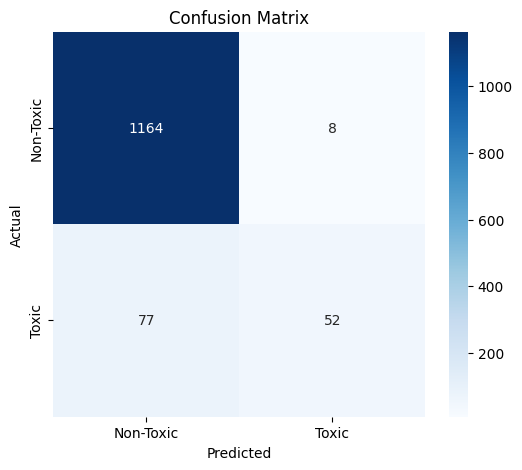

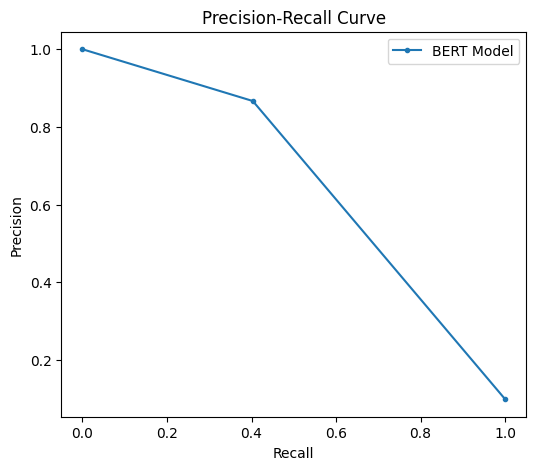

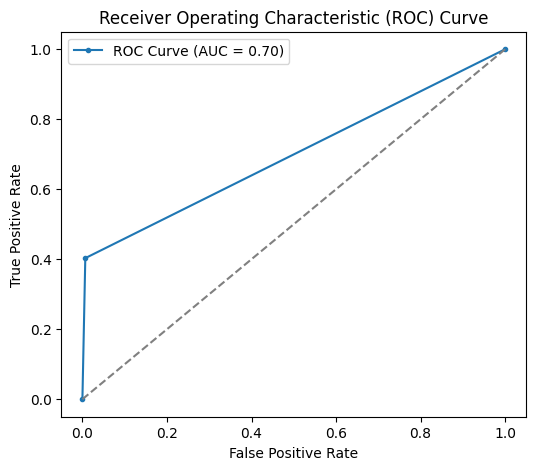

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
import numpy as np

def plot_results(all_labels, all_preds):
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, marker='.', label='BERT Model')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, marker='.', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def evaluate_and_plot(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # Print Evaluation Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='micro')
    auc_roc = roc_auc_score(all_labels, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    fpr, fnr = fp / (fp + tn), fn / (fn + tp)
    
    print(f"Micro Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    
    # Plot Results
    plot_results(all_labels, all_preds)

# Call the function after training
evaluate_and_plot(model, test_loader)